<a href="https://colab.research.google.com/github/gaolichen/machine-learning-examples/blob/main/deepchem/deepchem_muv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
!python3 -m pip install rdkit-pypi

In [31]:
"""
Script that trains TF multitask models on MUV dataset.
"""
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals

import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from muv_datasets import load_muv
from graph_model import GraphConvModel
import metrics
import models
import optimizers

def get_featurizer(model_name):
  if model_name == 'graphconv':
    return 'graphconv'
  else:
    return 'ECFP'

def create_model(model_name, n_tasks, batch_size = 64):
  rate = optimizers.ExponentialDecay(0.001, 0.8, 1000)

  if model_name == 'graphconv':
    return GraphConvModel(
        n_tasks,
        learning_rate = rate,
        batch_size=batch_size,
        mode='classification')
    
  elif model_name == 'tf':
    return models.MultitaskClassifier(
        n_tasks,
        n_features=1024,
        dropouts=[.5],
        layer_sizes = [100],
        learning_rate=rate,
        weight_init_stddevs=[.1], 
        batch_size=64,
        verbosity="high")
  else:
    return None  

def run_muv(model_name, epochs = 10):
    print('loading data')
    # Load MUV data
    np.random.seed(123)
    muv_tasks, muv_datasets, transformers = load_muv(
        splitter='stratified',
        featurizer=get_featurizer(model_name))
    train_dataset, valid_dataset, test_dataset = muv_datasets

    print('building model')
    model = create_model(model_name, len(muv_tasks))

    print('fitting...')
    # Fit trained model
    %time loss = model.fit(train_dataset, nb_epoch=epochs)
    #print(f'loss={loss}')

    metric = metrics.Metric(metrics.roc_auc_score, np.mean, mode="classification")
    # Evaluate train/test scores
    print('evaluating...')
    train_scores = model.evaluate(train_dataset, [metric], transformers)
    valid_scores = model.evaluate(valid_dataset, [metric], transformers)
    test_scores = model.evaluate(test_dataset, [metric], transformers)
    return train_scores, valid_scores, test_scores

def plot_muv_scores(scores):
    plt.rcdefaults()
    fig, ax = plt.subplots()
    model_names = list(scores.keys())
    roc_auc = [scores[name] for name in model_names]

    y_pos = np.arange(len(model_names))

    ax.barh(y_pos, roc_auc, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(model_names)
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('roc-auc')
    ax.set_xticks([i*0.1 for i in range(11)])
    ax.set_title('Performance on muv')
    
    for i, v in enumerate(roc_auc):
      ax.text(v + 0.01, i + .1, str(round(v, 3)), color='blue', fontweight='bold')

    plt.show()

In [32]:
train_scores_tf, valid_scores_tf, test_scores_tf = run_muv('tf', epochs = 2)
print('tf Train scores', train_scores_tf)
print('tf Validation scores', valid_scores_tf)
print('tf Test scores', test_scores_tf)


loading data
save_folder= ./muv-featurized/CircularFingerprint_size_1024/RandomStratifiedSplitter
save_dir= ./muv-featurized/CircularFingerprint_size_1024/RandomStratifiedSplitter/BalancingTransformer
building model
fitting...
CPU times: user 4.82 s, sys: 666 ms, total: 5.49 s
Wall time: 4.82 s
evaluating...
tf Train scores {'mean-roc_auc_score': 0.9815336055203626}
tf Validation scores {'mean-roc_auc_score': 0.7079894479200993}
tf Test scores {'mean-roc_auc_score': 0.6255126565668305}


In [33]:
train_scores_gc, valid_scores_gc, test_scores_gc = run_muv('graphconv', epochs = 10)
print('graphconv Train scores', train_scores_gc)
print('graphconv Validation scores', valid_scores_gc)
print('graphconv Test scores', test_scores_gc)


loading data
save_folder= ./muv-featurized/ConvMolFeaturizer/RandomStratifiedSplitter
save_dir= ./muv-featurized/ConvMolFeaturizer/RandomStratifiedSplitter/BalancingTransformer
building model
fitting...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_9/Reshape_14:0", shape=(253,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_9/Reshape_13:0", shape=(253, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_9/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:450: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_9/Reshape_17:0", shape=(1674,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_4/graph_pool_9/

CPU times: user 4min 15s, sys: 19.9 s, total: 4min 34s
Wall time: 3min 23s
evaluating...
graphconv Train scores {'mean-roc_auc_score': 0.9289569402849571}
graphconv Validation scores {'mean-roc_auc_score': 0.7570871035897755}
graphconv Test scores {'mean-roc_auc_score': 0.8036689980592765}


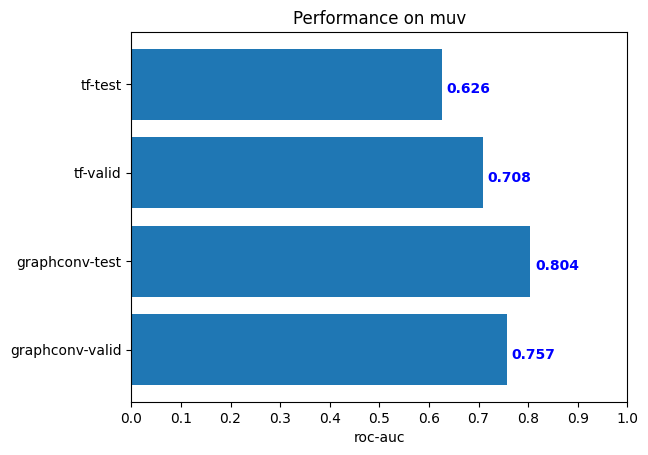

In [35]:
res = {'tf-test': test_scores_tf['mean-roc_auc_score'],
       'tf-valid': valid_scores_tf['mean-roc_auc_score'],
       'graphconv-test': test_scores_gc['mean-roc_auc_score'],
       'graphconv-valid': valid_scores_gc['mean-roc_auc_score']}
plot_muv_scores(res)
